In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorboard
import torchvision
import torchvision.transforms as transforms
import torchaudio

import matplotlib.pyplot as plt

- training details
- randomly sample 224×224 crops for data augmentation.
- We use a mini-batch size of 256 images for fine-tuning
- The learning rate starts from 0.1 and is divided by 10 when the error plateaus, and the models are trained for up to 60 × 10^4 iterations.
- We use a weight decay of 0.0001 and a momentum of 0.9. We do not use dropout
- We initialize the learning rate for the pre-trained network to be 0.01

# Load ImageNet

In [2]:
# make trainset using /home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train 
trainset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/train', 
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

# make valset using /home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val 
valset = torchvision.datasets.ImageFolder(
    root='/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/val', 
    transform = transforms.Compose([
         transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
)

In [3]:
mini_batch_size = 256
# make trainloader
train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

# make valloader
val_loader = torch.utils.data.DataLoader(
    valset, batch_size=mini_batch_size, shuffle=True, num_workers=4
)

In [4]:
# mini_batch_size = 256
print(f"mini_batch_size : {mini_batch_size}")

# check the size of trainset and valset
print(f"len(trainset) : {len(trainset)}") # the number of train images = 1,281,167
print(f"len(valset) : {len(valset)}")     # the number of val images   =    50,000

# check the size of train_loader and val_loader
print(f"len(train_loader) : {len(train_loader)}")  # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
print(f"len(val_loader) : {len(val_loader)}")      # the number of val batches   =   196 (   50,000 / mini_batch_size)

mini_batch_size : 256
len(trainset) : 1281167
len(valset) : 50000
len(train_loader) : 5005
len(val_loader) : 196


In [5]:
num_train_examples = len(trainset)
num_val_examples = len(valset)
num_train_batch = len(train_loader) # the number of train batches = 5,005 (1,281,167 / mini_batch_size)
num_val_batch = len(val_loader)     # the number of val batches   =   196 (   50,000 / mini_batch_size)

print(f"# train examples : {num_train_examples}")
print(f"# val examples : {num_val_examples}")
print(f"# train batches : {num_train_batch}")
print(f"# val batches : {num_val_batch}")

# train examples : 1281167
# val examples : 50000
# train batches : 5005
# val batches : 196


In [6]:
# check the structure of train_loader
for images, labels in train_loader:
    print(images.shape)
    print(labels.shape)
    break

torch.Size([256, 3, 224, 224])
torch.Size([256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee', 'water_ouzel', 'kite', 'bald_eagle', 'vulture', 'great_grey_owl', 'European_fire_salamander', 'common_newt', 'eft', 'spotted_salamander', 'axolotl', 'bullfrog', 'tree_frog', 'tailed_frog', 'loggerhead', 'leatherback_turtle', 'mud_turtle', 'terrapin', 'box_turtle', 'banded_gecko', 'common_iguana', 'American_chameleon', 'whiptail', 'agama', 'frilled_lizard', 'alligator_lizard', 'Gila_monster', 'green_lizard', 'African_chameleon', 'Komodo_dragon', 'African_crocodile', 'American_alligator', 'triceratops', 'thunder_snake', 'ringneck_snake', 'hognose_snake', 'green_snake', 'king_snake', 'garter_snake', 'water_snake', 'vine_snake', 'night_snake', 'boa_constrictor', 'rock_python', 'Indian_cobra', 'green_mamba', 'sea_snake', 'horned_viper', 'diamondback', 

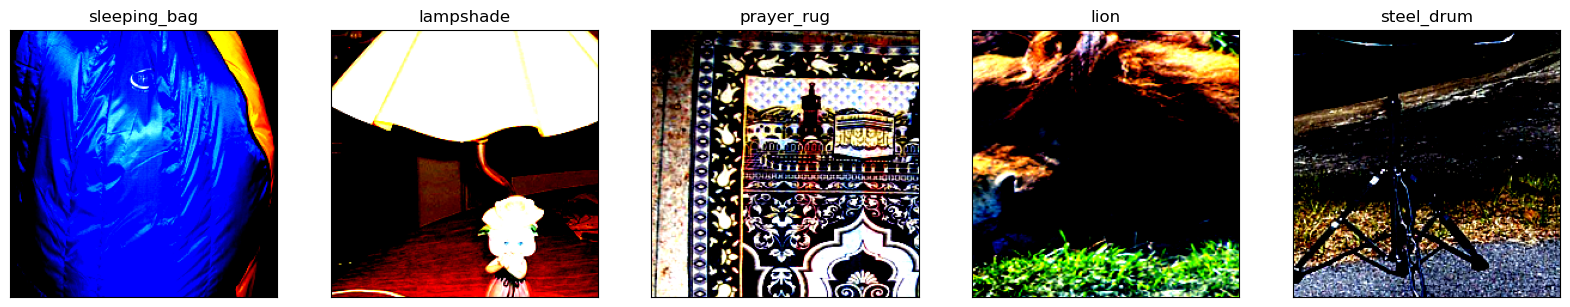

In [7]:
import random
import json

# 1000 classes
num_classes = 1000
with open('/home/hslee/Desktop/Datasets/ILSVRC2012_ImageNet/imagenet_class_index.json') as f:
    class_index = json.load(f)
# Get the human-readable class names
class_names = [class_index[str(i)][1] for i in range(num_classes)]
# Print the class names
print(class_names)


# check random 5 examples of trainset
fig = plt.figure(figsize=(20, 12))
for i, idx in enumerate(torch.randint(len(trainset), size=(5,))):
    ax = fig.add_subplot(1, 5, i+1, xticks=[], yticks=[])
    image, label = trainset[idx]
    ax.imshow(image.permute(1, 2, 0))
    ax.set_title(class_names[label])
    

# modeling ResNet34 by myself

* paper_resnet34 architecture : 
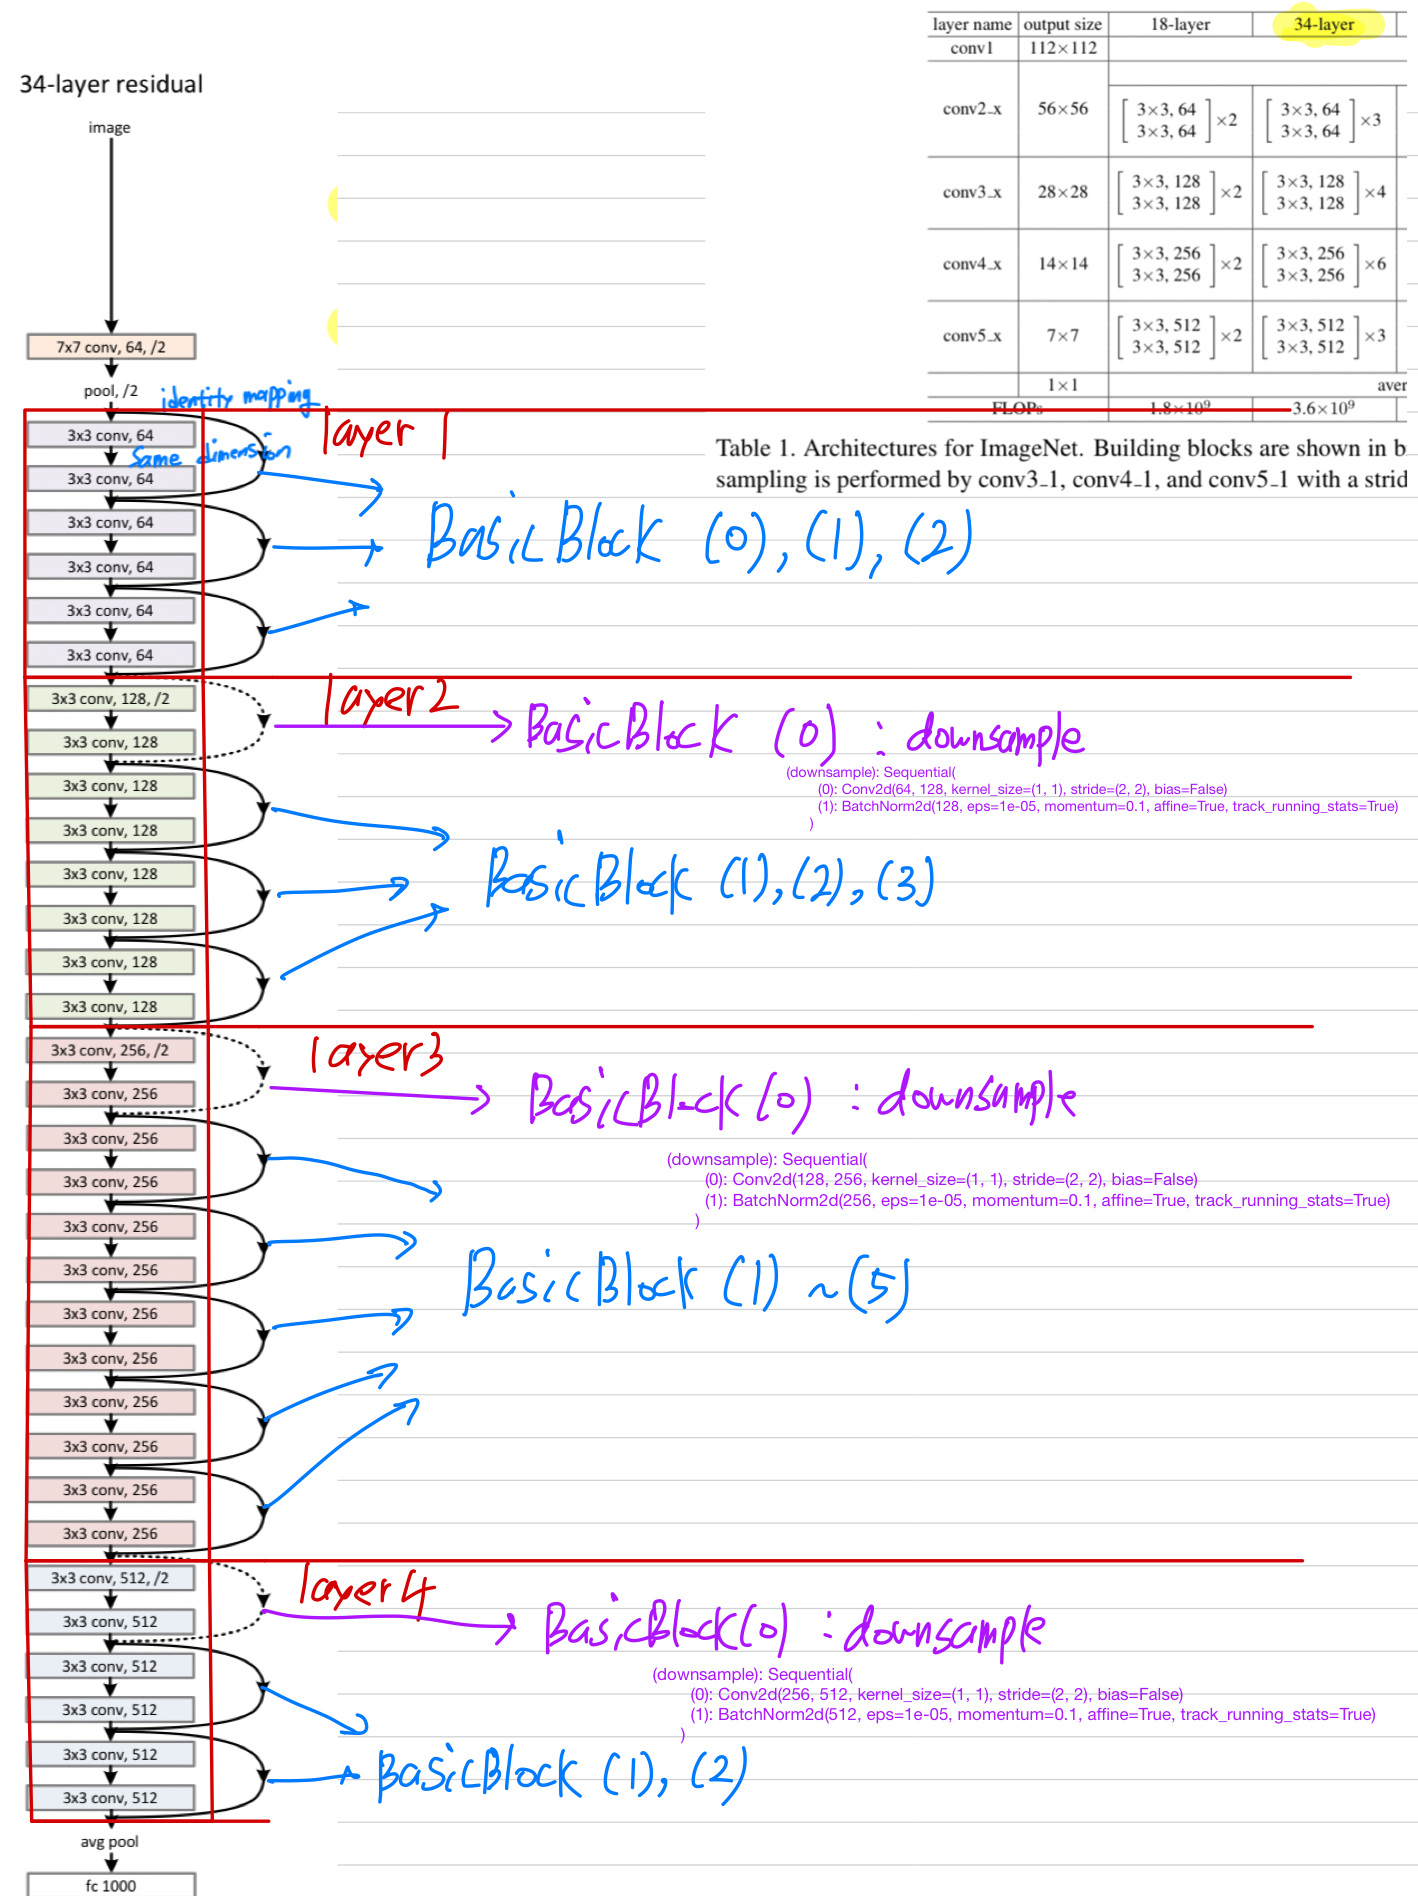


In [9]:
# Class BasicBlock(input)
class BasicBlock(nn.Module) :
    def __init__(self) :
        
        

# Class ResNet34 > Class BasicBlock
class MyResNet34(nn.Module) :
    def __init__(self) :
        
        num_classes : int = 1000
        self.relu = nn.ReLU(inplace=True)
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), # affine : True ? gamma, beta, track_running_stats : True ? running_mean, running_var
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        
        self.layer2 = nn.Sequential(
            BasicBlock(64, 64, 1),
            BasicBlock(64, 64, 1),
            BasicBlock(64, 64, 1),
        )
        self.layer3 = nn.Sequential(
            BasicBlock(64, 128, 2),
            BasicBlock(128, 128, 1),
            BasicBlock(128, 128, 1),
            BasicBlock(128, 128, 1),
        )
        self.layer4 = nn.Sequential(
            BasicBlock(128, 256, 2),
            BasicBlock(256, 256, 1),
            BasicBlock(256, 256, 1),
            BasicBlock(256, 256, 1),
            BasicBlock(256, 256, 1),
            BasicBlock(256, 256, 1),
        )
        self.layer5 = nn.Sequential(
            BasicBlock(256, 512, 2),
            BasicBlock(512, 512, 1),
            BasicBlock(512, 512, 1),
        )
        self.layer6 = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Linear(512, num_classes, bias=True),
        )
        
    def forward(self, x) : 
        # [Layer 1]
        ## Input size : 224 x 224 x 3 -> 112 x 112 x 64 -> Output size : 56 x 56 x 64
        x = self.layer1(x)
        
        # [Layer 2]
        ## Input size : 56 x 56 x 64, Output size : 56 x 56 x 64
        x = self.layer2(x)
        
        # [Layer 3]
        ## Input size : 56 x 56 x 64, Output size : 28 x 28 x 128
        x = self.layer3(x)
        
        # [Layer 4]
        ## Input size : 28 x 28 x 128, Output size : 7 x 7 x 512
        x = self.layer4(x)
        
        # [Layer 5]
        ## Input size : 7 x 7 x 512, Output size : 1 x 1 x 512
        x = self.layer5(x)
        
        # [Layer 6]
        ## Input size : (mini_batch_size) x 1 x 1 x 512 ->  1 x 1 x 512 -> Output size : 1 x 1 x 1000
        x = self.layer6(x)
        
        return x
        
        
        
        

IndentationError: expected an indented block after function definition on line 3 (275873885.py, line 8)